# Random Forest from scratch
---
In this notebook we build a radom forest model from scratch, following the instructions given on:
- https://www.analyticsvidhya.com/blog/2018/10/comprehensive-overview-machine-learning-part-1/
- https://www.analyticsvidhya.com/blog/2018/12/building-a-random-forest-from-scratch-understanding-real-world-data-products-ml-for-programmers-part-3/

## Step 1: Import basic libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# !pip install fastai==0.7.0  # run this if fastai is not installed yet
  # ERROR: jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, 
  # but you'll have prompt-toolkit 1.0.15 which is incompatible.

import pandas as pd
import numpy as np

from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from IPython.display import display
from sklearn import metrics

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

## Step 2: Load and preprocess data

This part is taken from: https://www.analyticsvidhya.com/blog/2018/10/comprehensive-overview-machine-learning-part-1/

In [3]:
# Option 1: directly download dataset via kaggle API

# !pip install --user kaggle
# kaggle competitions download -c bluebook-for-bulldozers  # throws error

In [11]:
# Option 2: manually download dataset from kaggle and load it with pandas

df_raw = pd.read_csv('data/Train.csv', 
                     parse_dates=["saledate"],  # convert this column to datetime
                     low_memory=False)          # If 'True' (default), file is internally processed in chunks, 
                                                # resulting in lower memory use while parsing, but possibly mixed 
                                                # type inference. To ensure no mixed types set to 'False'.
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# transform the target variable by taking its log 
# (since kaggle evaluation metric is RMSLE, i.e. the RMSE between the log values of the result)

df_raw.SalePrice = np.log(df_raw.SalePrice)

In [14]:
# convert all categorical columns into numbers to be used in RF model later (otherwise it will throw an error)

# 1) use train_cats function from fastai to convert all categorical variables into numbers
#    while also taking care that some categorical variables are ordered (e.g. high > medium > low)

train_cats(df_raw)  # does it inplace by default
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

# 2) use add_datepart function from the fastai library to create categorical features from datetime
add_datepart(df_raw, 'saledate')
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [20]:
# check data types after conversion to categorical
df_raw.dtypes

SalesID                        int64
SalePrice                    float64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

In [21]:
# check for missing values
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [23]:
# impute missing values using the proc_df function from fastai
df, y, nas = proc_df(df_raw, 'SalePrice')

In [25]:
# save preprocessed data it in a feather format, as this let’s us access the data efficiently

# os.makedirs('data', exist_ok=True)
df.to_feather('data/bulldozers-raw')

## Step 3: Split data into train and test set
This and all following parts are taken from: https://www.analyticsvidhya.com/blog/2018/12/building-a-random-forest-from-scratch-understanding-real-world-data-products-ml-for-programmers-part-3/

In [ ]:
# read saved data
df_raw = pd.read_feather('data/bulldozers-raw')

In [33]:
# use proc_df function from fastai, which takes a data frame df and splits off the response variable, 
# and changes the df into an entirely numeric dataframe.

df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
df_trn.shape, y_trn.shape

((401125, 66), (401125,))

In [34]:
# split features and response variable into train and test set

def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid

X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

raw_train, raw_valid = split_vals(df_raw, n_trn)

In [36]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((389125, 66), (12000, 66), (389125,), (12000,))

In [37]:
# take a subset of data (2 features) to start with

x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

## Step 4: Define the set of inputs
- A set of features – **x**
- A target variable – **y**
- Number of trees in the random forest – **n_trees**
- A variable to define the sample size – **sample_sz**
- A variable for minimum leaf size – **min_leaf**
- A random seed for testing

In [38]:
# Note: this part will be used in the TreeEnsemble class later (see below)

def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
    np.random.seed(42)
    self.x, self.y, self.sample_sz, self.min_leaf = x,y, sample_sz, min_leaf
    self.trees = [self.create_tree() for i in range(n_trees)]

## Step 5: Define a function that uses a sample of data (with replacement) and creates a decision tree over the same.

In [39]:
# Note: this part will be used in the TreeEnsemble class later (see below)

def create_tree(self):
    rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
    return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)

## Step 6: Create a predict function. 
The mean of the predicted value from each tree for a particular row is returned as the final prediction.

In [40]:
# Note: this part will be used in the TreeEnsemble class later (see below)

def predict(self, x):
    return np.mean([t.predict(x) for t in self.trees], axis=0)

Now we combine all the above functions to create a class TreeEnsemble.

In [68]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

## Step 7: Create a class DecisionTree. 
We call DecisionTree in the function create_tree, so let’s define it here. A decision tree would have a set of independent variables, a target variable, and the index values. For now, we have created only one decision tree (we can make it recursive later).

In [65]:
# Note: this part will be used in the DecisionTree class later (see below)

class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf  # define x,y,index and minimum leaf size
        self.n,self.c = len(idxs), x.shape[1]   # number of rows and columns
        self.val = np.mean(y[idxs])  
        self.score = float('inf')
        self.find_varsplit()

## Step 8: Determine the best split point. 
For every column, we use the function find_better_split to identify a split point and then return the column name, value, and score for the split.

In [66]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf  # define x,y,index and minimum leaf size
        self.n,self.c = len(idxs), x.shape[1]   # number of rows and columns
        self.val = np.mean(y[idxs])  
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf-1 or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

## Step 9: Define a function that calculates the standard deviation

In [67]:
def std_agg(cnt, s1, s2): 
    return math.sqrt((s2/cnt) - (s1/cnt)**2)

## Step 10: Train our model and calculate predictions
Use 10 trees, a sample size of 1,000 and minimum leaf as 3.

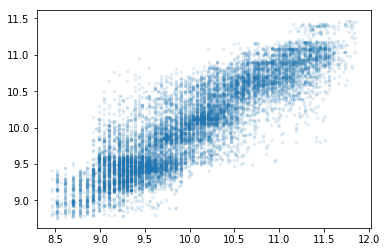

In [71]:
ens = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)
preds = ens.predict(X_valid.values)
plt.scatter(y_valid, preds, alpha=0.1, s=6);

In [72]:
metrics.r2_score(y_valid, preds)

0.77375534291526